In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.0          ✔ dplyr   0.8.5     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "telco-customer-churn"

In [2]:
library(MASS)
library(car)
library(caret)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




# **Read the Telco Churn Dataset**

In [3]:
telco <- read.csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

Get the glimpse of the dataset 

In [4]:
head(telco)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


There are all cateogorical features except Tenure, Monthly Charges and Total Charges. 

Visualize the NA's in the column

In [5]:
options(repr.plot.width = 10, repr.plot.height = 5)
missing_data <- telco %>% summarise_all(funs(sum(is.na(.))))
missing_data

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,11,0


There are 11 missing values in Total Charges column for this dataset

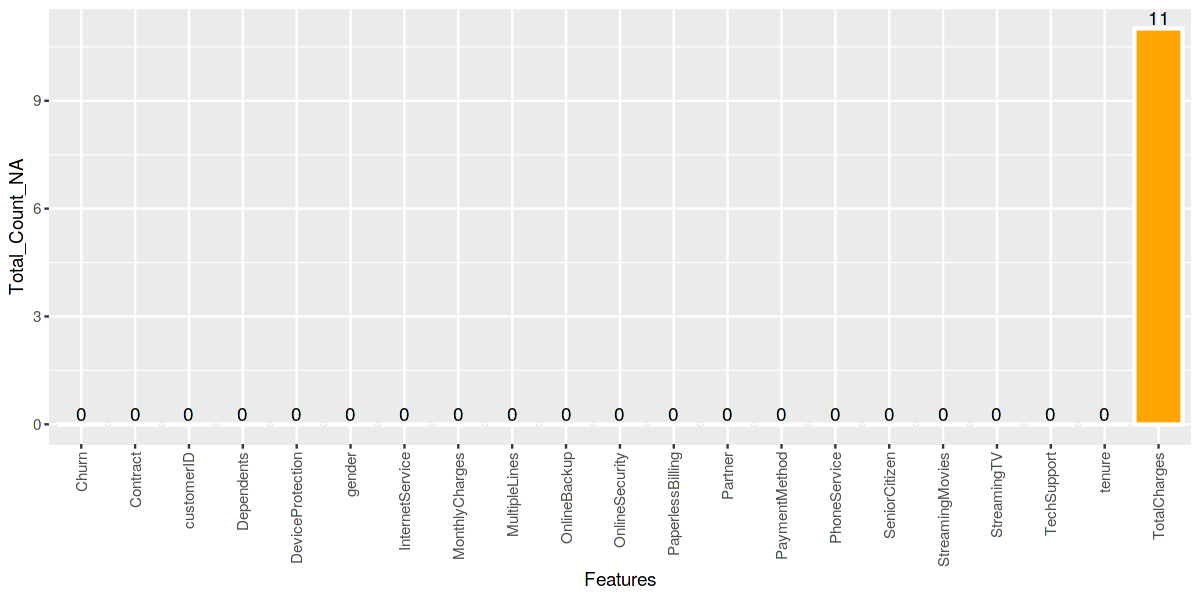

In [6]:
missing_data <- gather(missing_data, key='Features', value='Total_Count_NA')
ggplot(missing_data, aes(x = reorder(Features, Total_Count_NA),y = Total_Count_NA)) +
geom_bar(stat = "identity", fill="orange", aes(color = I('white')), size=0.9) +
geom_text(aes(label=Total_Count_NA), position=position_dodge(width=0.9), vjust=-0.25) +
xlab('Features') +
# coord_flip() +
theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5))

In [7]:
telco <- telco[complete.cases(telco),] # to remove those 11 NA observations 

# factorize SeniorCitizen 
telco$SeniorCitizen <- as.factor(ifelse(telco$SeniorCitizen==1, 'YES', 'NO'))

head(telco)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,7590-VHVEG,Female,NO,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,5575-GNVDE,Male,NO,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,3668-QPYBK,Male,NO,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,7795-CFOCW,Male,NO,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,9237-HQITU,Female,NO,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,9305-CDSKC,Female,NO,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


In [8]:
summary(telco)

      customerID      gender     SeniorCitizen Partner    Dependents
 0002-ORFBO:   1   Female:3483   NO :5890      No :3639   No :4933  
 0003-MKNFE:   1   Male  :3549   YES:1142      Yes:3393   Yes:2099  
 0004-TLHLJ:   1                                                    
 0011-IGKFF:   1                                                    
 0013-EXCHZ:   1                                                    
 0013-MHZWF:   1                                                    
 (Other)   :7026                                                    
     tenure      PhoneService          MultipleLines     InternetService
 Min.   : 1.00   No : 680     No              :3385   DSL        :2416  
 1st Qu.: 9.00   Yes:6352     No phone service: 680   Fiber optic:3096  
 Median :29.00                Yes             :2967   No         :1520  
 Mean   :32.42                                                          
 3rd Qu.:55.00                                                          
 Max.   :7

Cateogorize all the continous features by determining bins for each :
1. Tenure : (in months convert to years) 
2. TotalCharges : (in $$)
3. Monthly Charges : (in $$)

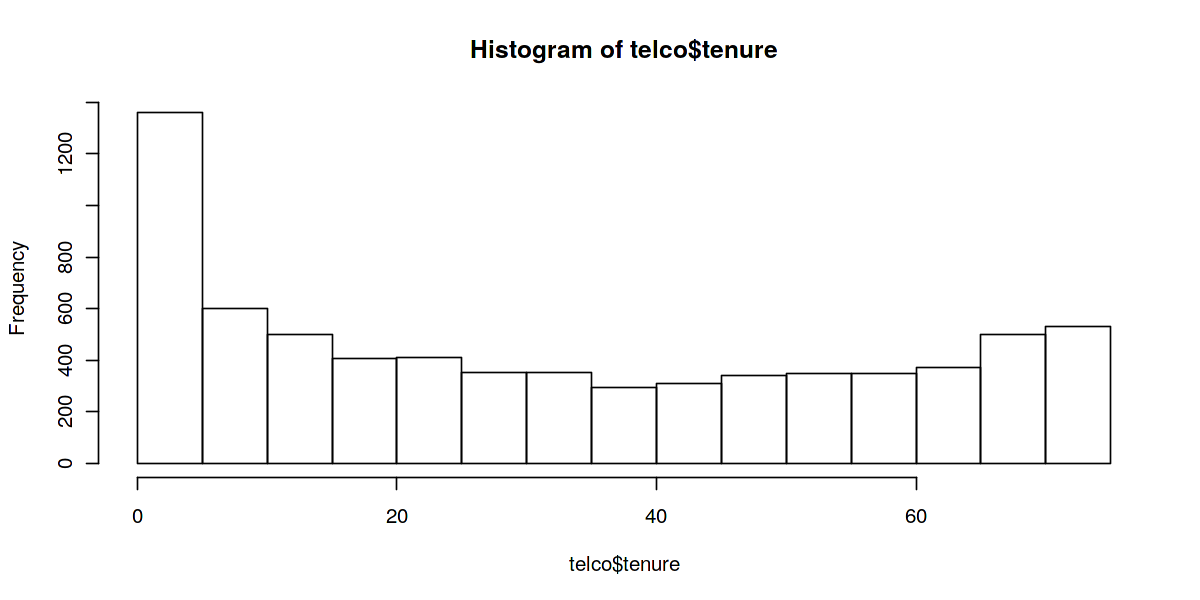

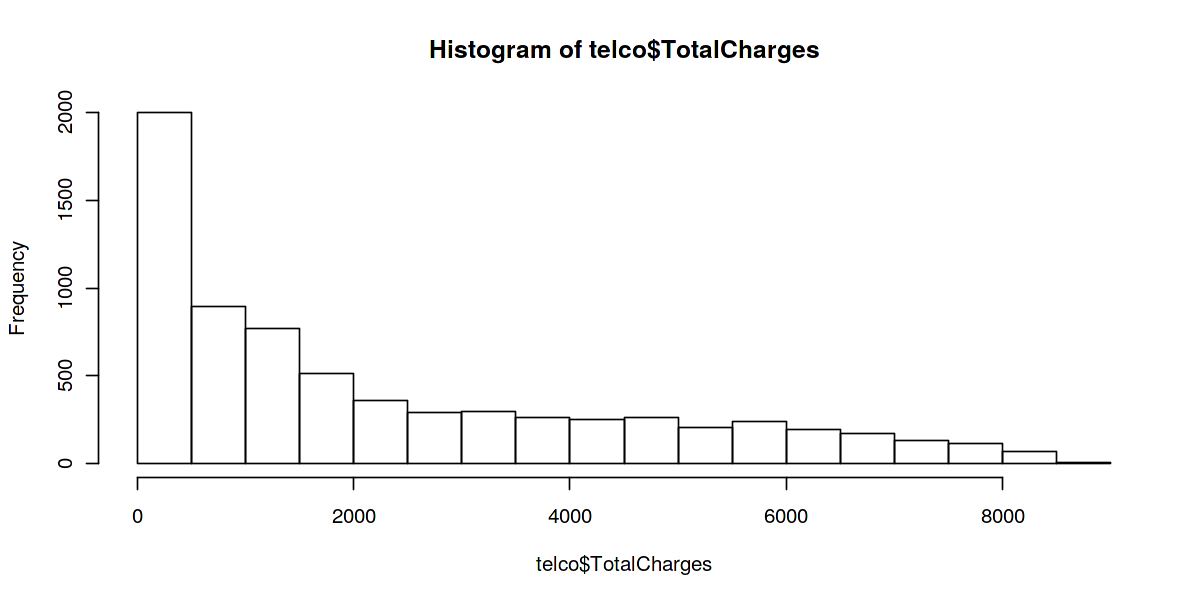

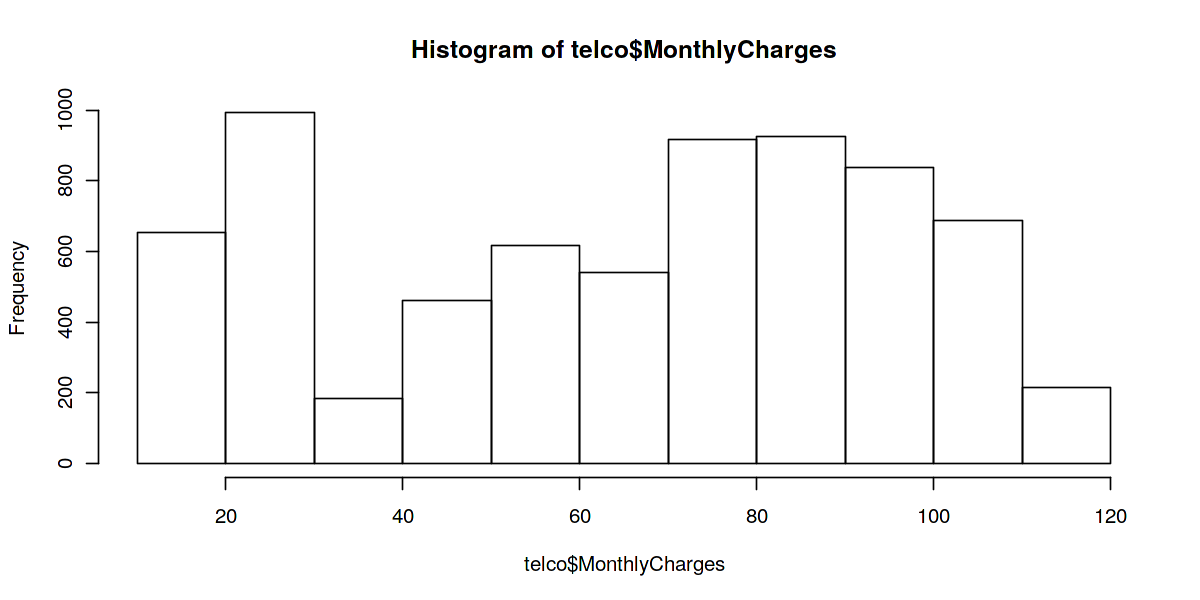

In [9]:
# visualize in bar graph

hist(telco$tenure)
hist(telco$TotalCharges)
hist(telco$MonthlyCharges)

Find correlation between these three continous features 

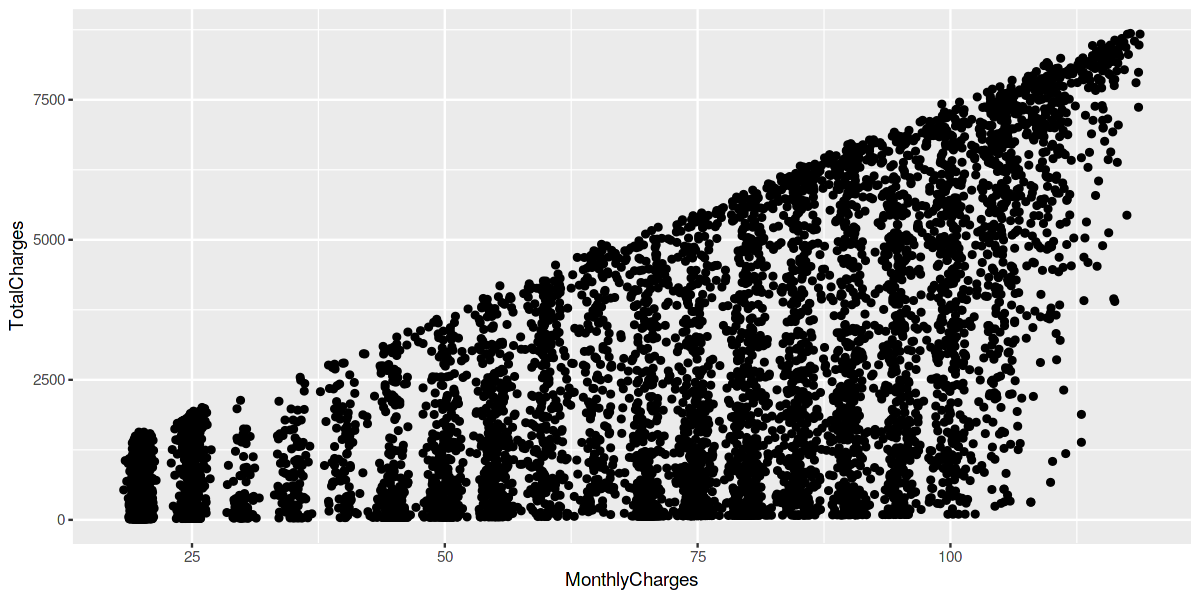

In [10]:
ggplot(data = telco) +
geom_point(mapping = aes(x= MonthlyCharges, y= TotalCharges))

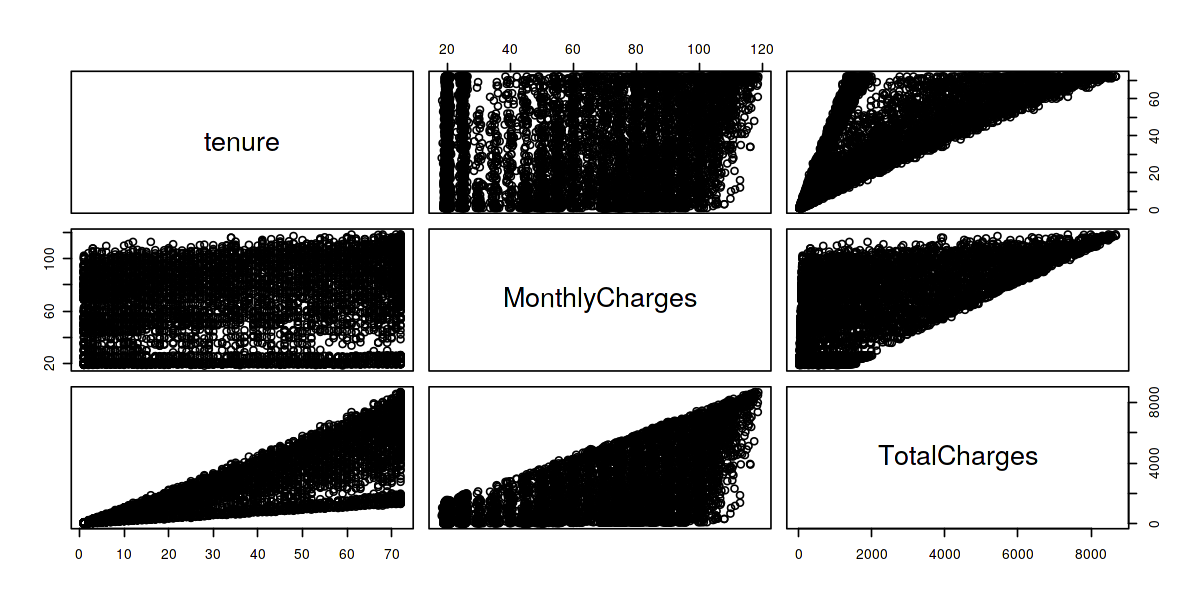

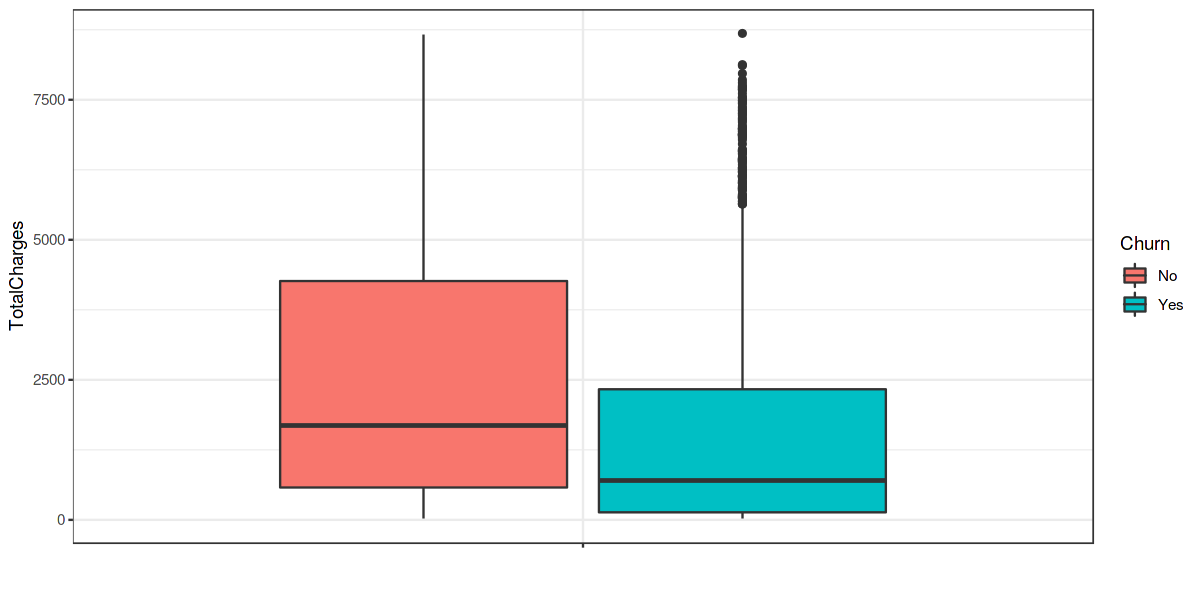

In [11]:
pairs(telco[,c('tenure','MonthlyCharges','TotalCharges')])

ggplot(telco, aes(y= TotalCharges, x = "", fill = Churn)) + 
geom_boxplot()+ 
theme_bw()+
xlab(" ")

Total Charges have positive correlation with Monthly Charges

**Data Cleaning**

* *Standarsiding continous features*

In [12]:
# scale the continous variables 
telco_scaled <- telco[,c("tenure", "MonthlyCharges", "TotalCharges")]
telco_scaled <- data.frame(scale(telco_scaled))
head(telco_scaled)

,tenure,MonthlyCharges,TotalCharges
,<dbl>,<dbl>,<dbl>
1,-1.28015700,-1.1616113,-0.9941234
2,0.06429811,-0.2608594,-0.1737275
3,-1.23941594,-0.3638974,-0.9595809
4,0.51244982,-0.7477972,-0.1952338
5,-1.23941594,0.1961642,-0.9403906
6,-0.99496955,1.1584066,-0.6453233


*Creating derived features*

For Tenure, the data is represented in months. Min: 1 and Max: 72.
We can create bins as :
* 0-1 year
* 1-2 years
* 2-3 years
* 3-4 years
* 4-5 years
* 5-6 years

In [13]:
telco <- mutate(telco, tenure_bin = tenure)
# head(telco)

telco$tenure_bin[telco$tenure_bin >=0 & telco$tenure_bin <= 12] <- '0-1 year'
telco$tenure_bin[telco$tenure_bin > 12 & telco$tenure_bin <= 24] <- '1-2 years'
telco$tenure_bin[telco$tenure_bin > 24 & telco$tenure_bin <= 36] <- '2-3 years'
telco$tenure_bin[telco$tenure_bin > 36 & telco$tenure_bin <= 48] <- '3-4 years'
telco$tenure_bin[telco$tenure_bin > 48 & telco$tenure_bin <= 60] <- '4-5 years'
telco$tenure_bin[telco$tenure_bin > 60 & telco$tenure_bin <= 72] <- '5-6 years'

telco$tenure_bin <- as.factor(telco$tenure_bin)
head(telco)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,7590-VHVEG,Female,NO,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-1 year
2,5575-GNVDE,Male,NO,No,No,34,Yes,No,DSL,Yes,⋯,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2-3 years
3,3668-QPYBK,Male,NO,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-1 year
4,7795-CFOCW,Male,NO,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3-4 years
5,9237-HQITU,Female,NO,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-1 year
6,9305-CDSKC,Female,NO,No,No,8,Yes,Yes,Fiber optic,No,⋯,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,0-1 year


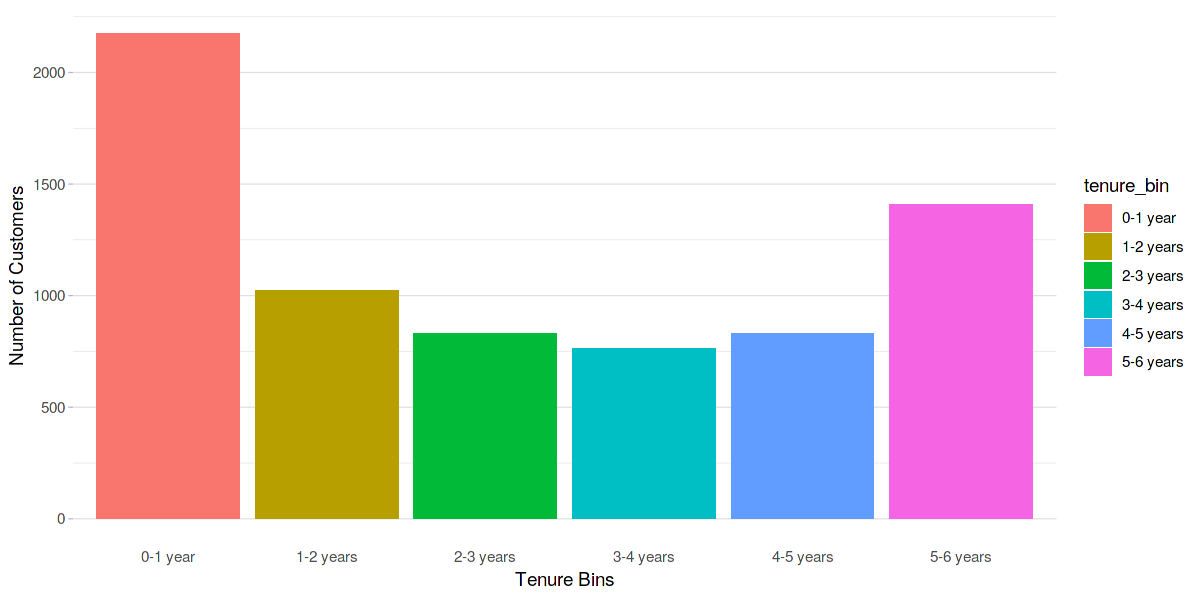

In [14]:
# plot the tenure bin 
ggplot(telco, aes(tenure_bin,fill=tenure_bin)) +
    geom_bar()+
    theme_light() +
    theme(
    panel.grid.major.x = element_blank(),
    panel.border = element_blank(),
    axis.ticks.x = element_blank()
    ) +
    xlab("Tenure Bins") +
    ylab("Number of Customers")

0-1 year clearly have more customers than any other. 

In [15]:
telco <- data.frame(lapply(telco, function(x) {
                  gsub("No internet service", "No", x)}))

telco <- data.frame(lapply(telco, function(x) {
                  gsub("No phone service", "No", x)}))

# head(telco)
telco_cat <- telco[,-c(1,3,6,19,20)] # removed senior citiznes. Because all the data points were no and for one-hot encoding 
# to perform sing model.matrix we would need 2 or more values 
# head(telco_cat)
#Creating Dummy Variables
dummy<- data.frame(sapply(telco_cat,function(x) data.frame(model.matrix(~x-1,data =telco_cat))[,-1]))

head(dummy)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService.xFiber.optic,InternetService.xNo,OnlineSecurity,OnlineBackup,DeviceProtection,⋯,PaperlessBilling,PaymentMethod.xCredit.card..automatic.,PaymentMethod.xElectronic.check,PaymentMethod.xMailed.check,Churn,tenure_bin.x1.2.years,tenure_bin.x2.3.years,tenure_bin.x3.4.years,tenure_bin.x4.5.years,tenure_bin.x5.6.years
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0,0,0,0,0,0,1,0,⋯,1,0,1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,1,0,1,⋯,0,0,0,1,0,0,1,0,0,0
3,1,0,0,1,0,0,0,1,1,0,⋯,1,0,0,1,1,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,1,⋯,0,0,0,0,0,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,⋯,1,0,1,0,1,0,0,0,0,0
6,0,0,0,1,1,1,0,0,0,1,⋯,1,0,1,0,1,0,0,0,0,0


*Adding the resacled data for continous features*

In [16]:
telco <- cbind(dummy, telco_scaled)
head(telco)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService.xFiber.optic,InternetService.xNo,OnlineSecurity,OnlineBackup,DeviceProtection,⋯,PaymentMethod.xMailed.check,Churn,tenure_bin.x1.2.years,tenure_bin.x2.3.years,tenure_bin.x3.4.years,tenure_bin.x4.5.years,tenure_bin.x5.6.years,tenure,MonthlyCharges,TotalCharges
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,-1.28015700,-1.1616113,-0.9941234
2,1,0,0,1,0,0,0,1,0,1,⋯,1,0,0,1,0,0,0,0.06429811,-0.2608594,-0.1737275
3,1,0,0,1,0,0,0,1,1,0,⋯,1,1,0,0,0,0,0,-1.23941594,-0.3638974,-0.9595809
4,1,0,0,0,0,0,0,1,0,1,⋯,0,0,0,0,1,0,0,0.51244982,-0.7477972,-0.1952338
5,0,0,0,1,0,1,0,0,0,0,⋯,0,1,0,0,0,0,0,-1.23941594,0.1961642,-0.9403906
6,0,0,0,1,1,1,0,0,0,1,⋯,0,1,0,0,0,0,0,-0.99496955,1.1584066,-0.6453233


**Splitting Trainig and Validation Data**

In [17]:
library(caTools)
set.seed(777)

indices = sample.split(telco$Churn, SplitRatio = 0.7)
telco_train <- telco[indices,]
telco_validation <- telco[!(indices),]

# Logistic Regression
Build logistic regression model 

In [18]:
logit.fit <- glm(Churn ~., data=telco_train, family = "binomial" )
beta <- logit.fit$coefficients[-1]
beta

gender                                Partner 
                           -0.02058824                            -0.03605836 
                            Dependents                           PhoneService 
                           -0.12795153                             0.02479414 
                         MultipleLines           InternetService.xFiber.optic 
                            0.45749149                             1.59958515 
                   InternetService.xNo                         OnlineSecurity 
                           -1.73315193                            -0.20434778 
                          OnlineBackup                       DeviceProtection 
                           -0.02165980                             0.10811444 
                           TechSupport                            StreamingTV 
                           -0.22038241                             0.53488717 
                       StreamingMovies                     Contract.xOne.year 
                            0.61707809                            -0.68124671 
                    Contract.xTwo.year                       PaperlessBilling 
                           -1.53200513                             0.32628238 
PaymentMethod.xCredit.card..automatic.        PaymentMethod.xElectronic.check 
                           -0.01713320                             0.43730537 
           PaymentMethod.xMailed.check                  tenure_bin.x1.2.years 
                            0.04701743                             0.27470689 
                 tenure_bin.x2.3.years                  tenure_bin.x3.4.years 
                            0.85037262                             1.99745944 
                 tenure_bin.x4.5.years                  tenure_bin.x5.6.years 
                            2.50481656                             3.13865778 
                                tenure                         MonthlyCharges 
                           -2.34460322                            -0.94444754 
                          TotalCharges 
                            0.36462883

In [19]:
summary(logit.fit)


Call:
glm(formula = Churn ~ ., family = "binomial", data = telco_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9960  -0.6709  -0.2694   0.6648   3.3764  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                            -3.68521    1.58351  -2.327 0.019952 *  
gender                                 -0.02059    0.07861  -0.262 0.793394    
Partner                                -0.03606    0.09370  -0.385 0.700367    
Dependents                             -0.12795    0.10726  -1.193 0.232907    
PhoneService                            0.02479    0.78338   0.032 0.974751    
MultipleLines                           0.45749    0.21577   2.120 0.033983 *  
InternetService.xFiber.optic            1.59959    0.96599   1.656 0.097740 .  
InternetService.xNo                    -1.73315    0.97747  -1.773 0.076211 .  
OnlineSecurity                         -0.20435    0.21606  -0.946 0.344249   

Computing Stepwise Regression 

In [20]:
logit2.fit <- stepAIC(logit.fit, direction="both")

Start:  AIC=4051.27
Churn ~ gender + Partner + Dependents + PhoneService + MultipleLines + 
    InternetService.xFiber.optic + InternetService.xNo + OnlineSecurity + 
    OnlineBackup + DeviceProtection + TechSupport + StreamingTV + 
    StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xCredit.card..automatic. + 
    PaymentMethod.xElectronic.check + PaymentMethod.xMailed.check + 
    tenure_bin.x1.2.years + tenure_bin.x2.3.years + tenure_bin.x3.4.years + 
    tenure_bin.x4.5.years + tenure_bin.x5.6.years + tenure + 
    MonthlyCharges + TotalCharges

                                         Df Deviance    AIC
- PhoneService                            1   3995.3 4049.3
- OnlineBackup                            1   3995.3 4049.3
- PaymentMethod.xCredit.card..automatic.  1   3995.3 4049.3
- gender                                  1   3995.3 4049.3
- PaymentMethod.xMailed.check             1   3995.4 4049.4
- Partner                        

In [21]:
logit2.fit$coefficients[-1]

Dependents                   MultipleLines 
                     -0.1464550                       0.4356900 
   InternetService.xFiber.optic             InternetService.xNo 
                      1.5114462                      -1.6701368 
                 OnlineSecurity                     TechSupport 
                     -0.2230346                      -0.2297762 
                    StreamingTV                 StreamingMovies 
                      0.5155952                       0.5949605 
             Contract.xOne.year              Contract.xTwo.year 
                     -0.6737457                      -1.5193893 
               PaperlessBilling PaymentMethod.xElectronic.check 
                      0.3237750                       0.4243775 
          tenure_bin.x1.2.years           tenure_bin.x2.3.years 
                      0.2713459                       0.8410171 
          tenure_bin.x3.4.years           tenure_bin.x4.5.years 
                      1.9945802                       2.4864058 
          tenure_bin.x5.6.years                          tenure 
                      3.1180405                      -2.3550381 
                 MonthlyCharges                    TotalCharges 
                     -0.8590389                       0.3787120

In [22]:
summary(logit2.fit)


Call:
glm(formula = Churn ~ Dependents + MultipleLines + InternetService.xFiber.optic + 
    InternetService.xNo + OnlineSecurity + TechSupport + StreamingTV + 
    StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xElectronic.check + tenure_bin.x1.2.years + 
    tenure_bin.x2.3.years + tenure_bin.x3.4.years + tenure_bin.x4.5.years + 
    tenure_bin.x5.6.years + tenure + MonthlyCharges + TotalCharges, 
    family = "binomial", data = telco_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0052  -0.6664  -0.2706   0.6644   3.3868  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -3.57880    0.39064  -9.161  < 2e-16 ***
Dependents                      -0.14645    0.09787  -1.496 0.134540    
MultipleLines                    0.43569    0.10570   4.122 3.76e-05 ***
InternetService.xFiber.optic     1.51145    0.23236   6.505 7.78e-11 ***
Intern

> Removing features with higher p-values

In [23]:
logit.final <- glm(Churn ~ Dependents + MultipleLines + InternetService.xFiber.optic + 
    InternetService.xNo + OnlineSecurity + TechSupport + StreamingTV + 
    StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xElectronic.check + 
    tenure_bin.x2.3.years + tenure_bin.x3.4.years + tenure_bin.x4.5.years + 
    tenure_bin.x5.6.years, data=telco_train, family = "binomial" )

In [24]:
summary(logit.final)


Call:
glm(formula = Churn ~ Dependents + MultipleLines + InternetService.xFiber.optic + 
    InternetService.xNo + OnlineSecurity + TechSupport + StreamingTV + 
    StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xElectronic.check + tenure_bin.x2.3.years + 
    tenure_bin.x3.4.years + tenure_bin.x4.5.years + tenure_bin.x5.6.years, 
    family = "binomial", data = telco_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7499  -0.6724  -0.2820   0.7342   3.0842  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.70622    0.10557  -6.690 2.24e-11 ***
Dependents                      -0.22449    0.09593  -2.340  0.01927 *  
MultipleLines                    0.11410    0.08932   1.277  0.20143    
InternetService.xFiber.optic     0.66855    0.09574   6.983 2.90e-12 ***
InternetService.xNo             -1.06380    0.15592  -6.823 8.92e-12 ***
Onl

In [25]:
pred <- predict(logit.final, type = "response", newdata = telco_validation)
summary(pred)
telco_validation$prob <- pred

# Using probability cutoff of 50%.

pred_churn <- factor(ifelse(pred >= 0.50, "Yes", "No"))
actual_churn <- factor(ifelse(telco_validation$Churn==1,"Yes","No"))
table(actual_churn,pred_churn)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005523 0.044035 0.183349 0.262861 0.453151 0.783706 

            pred_churn
actual_churn   No  Yes
         No  1382  167
         Yes  276  285

In [26]:
conf_final <- confusionMatrix(pred_churn, actual_churn, positive = "Yes")
accuracy <- conf_final$overall[1]
accuracy

Accuracy 
0.7900474